# Vertex Dynamics Models
> Simulation codes

---

In [ ]:
#hide
from vertex_simulation.primitives import *
from vertex_simulation.simulation import *
import torch, numpy as np, matplotlib.pylab as plt
from mpl_toolkits.mplot3d import axes3d
# after you modify this notebook use "nbdev_build_docs" to build the docs (and readme.md)
# and nbdev_clean_nbs to remove notebook metadata before pushing it
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device=torch.device('cpu')
if torch.cuda.device_count():
    device=torch.device('cuda:1')
dtype = torch.float32

## Anisotropic contractions

In [ ]:
import networkx as nx

In [ ]:
# let's seed RNG for sanity and reproducibility
np.random.seed(42)

# define cell monolayer
v_x,regions =unit_hexagons(10,10) # unit hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

In [ ]:
cell_graph = Monolayer(vertices=Vertex(v_x.copy().tolist(),dtype=dtype), 
                       edges=torch.tensor(edge_list), 
                       cells=cells)
cell_graph.to_(device)

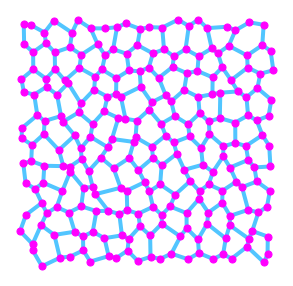

In [ ]:
Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

In [ ]:
# Define energy function
omega = torch.tensor([np.pi/2],dtype=dtype,device=device)
phase = torch.rand((len(edge_list),1)).type(dtype).to(device)
p_keep = 0.2 # fraction to keep active
e_ij_on = (torch.rand((len(edge_list),1))<p_keep).type(dtype).to(device)

def monolayer_energy(monolayer_,Tau):
    Perm = cell_graph.perimeter()
    Area = cell_graph.area()
    Leng = cell_graph.length()
    direction = cell_graph.direction()
    dir_coeff = torch.abs(direction[:,1])/torch.norm(direction,dim=1)/5
    
    gamma_ij  = e_ij_on*dir_coeff.view(-1,1)*torch.cos(omega*Tau+phase)**2
    gamma_ij_by_lij = Leng*gamma_ij
    Energy_tot = torch.sum(.01*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)
    return Energy_tot, gamma_ij

In [ ]:
# Networkx's edge ordering is different
edge_idx = dict(zip([tuple(e) for e in cell_graph.edges.tolist()],range(cell_graph.edges.shape[0])))
edge_idx_order = [edge_idx[e if e in edge_idx else (e[1],e[0])] for e in Gnx.edges ]
def draw_w_tension(i):
    pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {verts_frames[i]:2.3f}')
    #node_color=range(24), node_size=800, cmap=plt.cm.Blues
    nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',
            edge_color=line_tensions[i].numpy().squeeze()[edge_idx_order],edge_cmap=plt.cm.bwr)

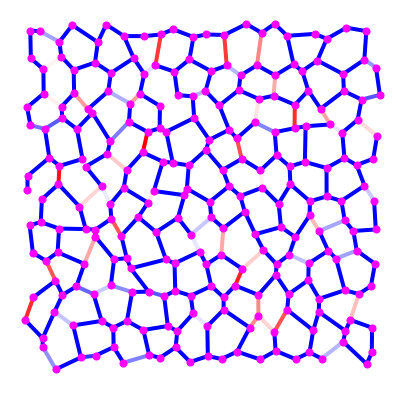

In [ ]:
_,Contractions = monolayer_energy(cell_graph,0)
fig = plt.figure(figsize=[7,7])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=50,width=4,node_color='#FF00FF',
            edge_color=Contractions.cpu().numpy().squeeze()[edge_idx_order],edge_cmap=plt.cm.bwr)

In [ ]:
# Simulation param-s
Dt = 2**-5 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
t_total = 2**10

cell_graph.vertices.requires_grad_(True)

Integration (Euler's method):
t=4.000: E=35.67; aver |dx/dt|= 0.059
t=8.000: E=34.76; aver |dx/dt|= 0.048
t=12.000: E=34.51; aver |dx/dt|= 0.044
t=16.000: E=34.39; aver |dx/dt|= 0.039
t=20.000: E=34.31; aver |dx/dt|= 0.04
t=24.000: E=34.26; aver |dx/dt|= 0.041
t=28.000: E=34.21; aver |dx/dt|= 0.039
t=32.000: E=34.18; aver |dx/dt|= 0.042


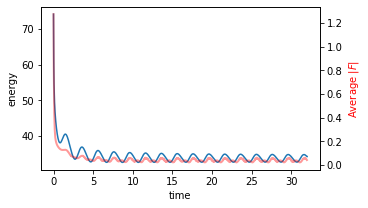

Perimeters:tensor([5.6231, 5.6199, 5.6397, 5.6598, 5.5882, 5.7048, 5.7683, 5.5669, 5.6403,
        5.5830, 5.7310, 5.8414, 5.7274, 5.6328, 5.6614, 5.7026, 5.6535, 5.6805,
        5.6697, 5.7937, 5.7443, 5.8000, 5.7793, 5.6898, 5.6722, 5.6743, 5.6634,
        5.6784, 5.5737, 5.6176, 5.7249, 5.6190, 5.5969, 5.6160, 5.5723, 5.5979,
        5.6130, 5.6378, 5.6973, 5.7394, 5.6438, 5.6492, 5.6106, 5.6326, 5.5816,
        5.7206, 5.6319, 5.6216, 5.6740, 5.5843, 5.5832, 5.6375, 5.7747, 5.6314,
        5.7283, 5.6383, 5.6726, 5.5823, 5.5723, 5.6710, 5.7691, 5.7786, 5.7408,
        5.6864, 5.7471, 5.7028, 5.6368, 5.7213, 5.6380, 5.6537, 5.6448, 5.7051,
        5.5829, 5.6178, 5.7516, 5.6785, 5.6829, 5.7714, 5.7724, 5.6801, 5.6023,
        5.7559, 5.6379, 5.5684, 5.6220, 5.5680, 5.8003, 5.8385, 5.6052, 5.7525,
        5.6569, 5.7615, 5.7184, 5.6407, 5.7881, 5.7037, 5.8783, 5.7354, 5.7283,
        5.6675], device='cuda:1')
Areas:tensor([2.2307, 2.2202, 2.2320, 2.2290, 2.2394, 2.2156, 2.2306, 2.223

In [ ]:
# Numerical integration
print('Integration (Euler\'s method):')

for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    t.append(t[-1]+Dt) # update last frame time
    # total potential energy of the system:
    E,Contractions = monolayer_energy(cell_graph,t[-1]) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    verts_t.append(cell_graph.vertices.x.detach().cpu().clone())
    verts_frames.append(t[-1])
    line_tensions.append(Contractions.detach().cpu().clone())
    
    if round((n+1)%(t_total/8))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( monolayer_energy( cell_graph,t[-1])[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import PIL

/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/mnt/mbi/home/shagirov/miniconda3/envs/pytorch/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


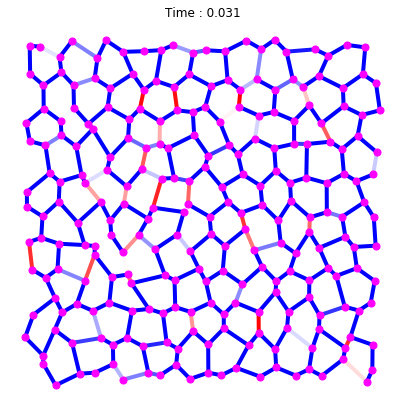

In [ ]:
fig = plt.figure(figsize=[7,7])
fig.clf()
ax = fig.subplots()
ax.axis(False);
draw_w_tension(0)
plt.show()
plt.close()

anim = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                               frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

In [ ]:
HTML(anim.to_jshtml()) 

**Save as GIF**

In [ ]:
# len(verts_t)
pil_images=[]
for i in range(0,len(verts_t),5):
    fig = plt.figure(figsize=[7,7])
    fig.clf()
    ax = fig.subplots()
    ax.axis(False);
    draw_w_tension(i)
#     plt.show()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(),
                                           canvas.tostring_rgb()) )
    plt.close()


In [ ]:
pil_images[0].save('sim_anisotropic_contraction.gif', format='GIF',
                   append_images=pil_images[1:], save_all=True, duration=100, loop=0)